In [5]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.precompute.accretion import PBHAccretionModel, Mdot_PR, Mdot_BHL
from dm21cm.precompute.halo import *
# from dm21cm.preprocessing.hmf import *
from dm21cm.utils import load_h5_dict, save_h5_dict

sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as dh_phys

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

# Build cmz table

In [2]:
def fix_cmz_numerical_issues(xs, ys, z):

    def accepted_lowz(xs, ys):
        m_max = 1.05
        m_min = 0.95
        xs_accepted = []
        ys_accepted = []

        for i, (x, y) in enumerate(zip(xs, ys)):
            if i == 0:
                xs_accepted.append(x)
                ys_accepted.append(y)
                continue
            if m_min < y/ys_accepted[-1] and y/ys_accepted[-1] < m_max:
                xs_accepted.append(x)
                ys_accepted.append(y)
        return xs_accepted, ys_accepted
    
    def accepted_highz(xs, ys, z):
        z_s = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])
        p0_s = np.array([3, 2.52, 2.35, 2.3, 2.2, 2.17, 2.14, 2.1, 2.1])
        p1_s = np.array([-0.055, -0.03, -0.025, -0.02, -0.015, -0.013, -0.012, -0.01, -0.01])
        p0 = np.interp(z, z_s, p0_s)
        p1 = np.interp(z, z_s, p1_s)
        y_upper = p0 + np.log10(xs) * p1
        xs_accepted = xs[ys < y_upper]
        ys_accepted = ys[ys < y_upper]
        return xs_accepted, ys_accepted

    xas, yas = accepted_lowz(xs, ys) if z < 20 else accepted_highz(xs, ys, z)
    log_ys_fixed = interpolate.interp1d(np.log(xas), np.log(yas), kind='linear', bounds_error=False, fill_value=np.min(np.log(ys)))(np.log(xs))
    return xs, np.exp(log_ys_fixed)

In [3]:
# build table

c_table = []

z_s = np.linspace(0, 100, 300)

for z in tqdm(z_s):
    hm = halomod.DMHaloModel(
        halo_concentration_model='Ludlow16',
        z = z, Mmin = 0., Mmax = 19, dlog10m = 0.025,
        mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
    )
    hm_m_s, hm_cmz_s = fix_cmz_numerical_issues(hm.m, hm.cmz_relation, z)
    c_table.append(hm_cmz_s)

c_table = np.array(c_table)

  0%|          | 0/300 [00:00<?, ?it/s]/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
100%|██████████| 300/300 [06:59<00:00,  1.40s/it]


In [7]:
data = {
    'z': z_s,
    'm': hm_m_s,
    'c': c_table,
    'units': 'c: [1], m: [Msun], z: [1]',
    'shapes': 'c: (z, m)',
}
save_h5_dict(WDIR + '/data/production/cmz_Ludlow16.h5', data)

# test

In [8]:
_CMZ_DATA = load_h5_dict(f"{os.environ['DM21CM_DIR']}/data/production/cmz_Ludlow16.h5")
_CMZ_M = _CMZ_DATA['m']
_CMZ_Z = _CMZ_DATA['z']
_CMZ_C = _CMZ_DATA['c']

In [11]:
from dm21cm.interpolators import interp1d

In [19]:
c_at_z = interp1d(_CMZ_C, _CMZ_Z, 10)
c_s = interp1d(c_at_z, _CMZ_M, jnp.array([1e3, 1e4, 1e5]))

In [20]:
c_s

Array([3.75421038, 3.59809533, 3.44131964], dtype=float64)

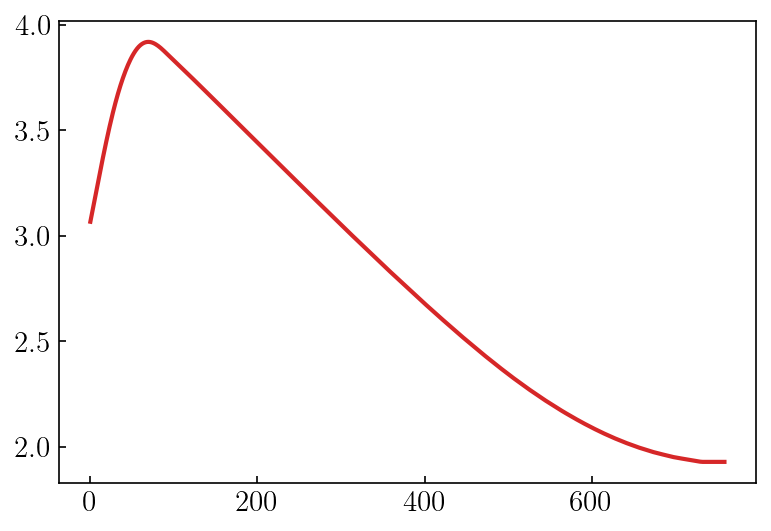

In [14]:
plt.plot(c_at_z)

# Test table

(1.0, 3.0)

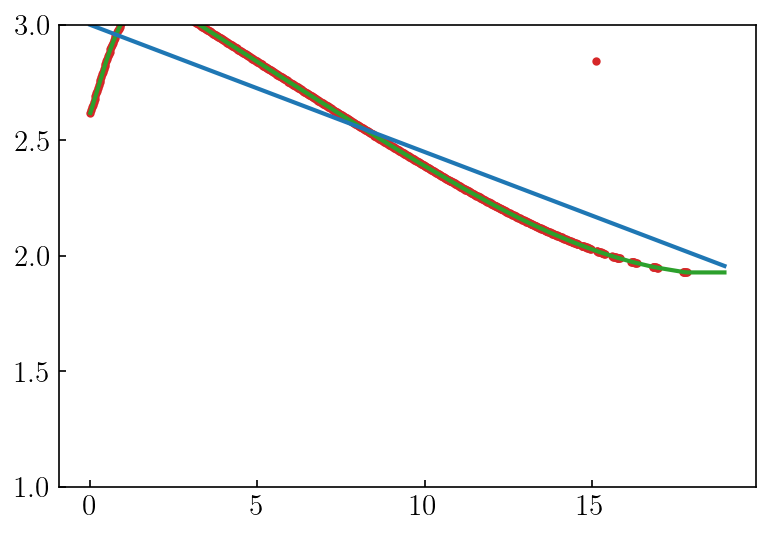

In [278]:
x = np.log10(hm.m)
plt.plot(x, hm.cmz_relation, '.')
hm_m_s, hm_cmz_s = fix_cmz_numerical_issues(hm.m, hm.cmz_relation, z)
plt.plot(x, hm_cmz_s)
plt.plot(x, 3 - x*0.055)
plt.ylim(1, 3)
# plt.xlim(1e-1, 1e1)

# halomod version

In [ ]:
am = PBHAccretionModel(accretion_type='PR-ADAF', c_in=23)
z = 10
m_halo = 1e8 # [M_sun]
c_halo = cmz(m_halo, z)
print(f'c = {c_halo:.4f}')
m_PBH = 100 # [M_sun]
f_PBH = 1

In [3]:
import hmf
import halomod

print(f'Using hmf version {hmf.__version__}')
print(f'Using halomod version {halomod.__version__}')

Using hmf version 3.4.4
Using halomod version 2.1.0


Halomod version  2.1.0


/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/concentration.py:595: UserWarning: Only use Ludlow16Empirical c(m,z) relation when using Planck-like cosmology
  warnings.warn(


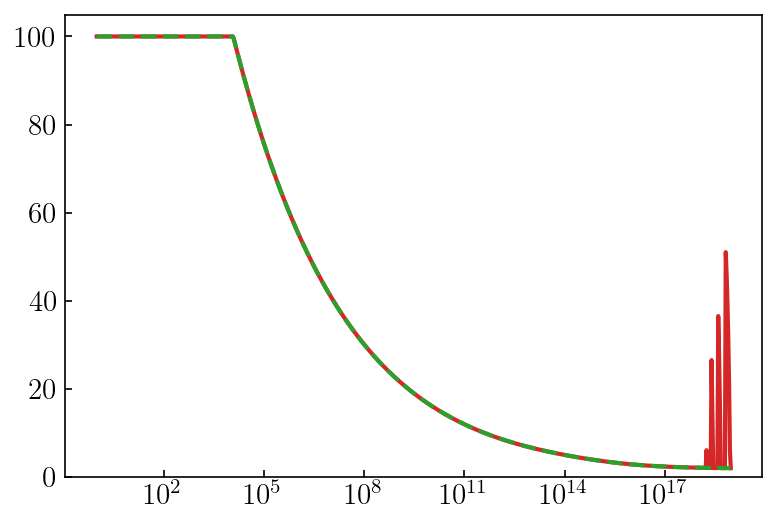

In [4]:
print('Halomod version ', halomod.__version__)
hm = halomod.DMHaloModel(
    halo_concentration_model='Ludlow16',
    z = 0, Mmin = 0., Mmax = 19, dlog10m = 0.025,
    mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
)
hm_m_s, hm_cmz_s = fix_cmz_numerical_issues(hm.m, hm.cmz_relation)
# np.save('tmpz0.npy', np.array([hm_m_s, hm_cmz_s]))
hme = halomod.DMHaloModel(
    halo_concentration_model='Ludlow16Empirical',
    z = 0, Mmin = 0., Mmax = 19, dlog10m = 0.025,
    mdef_model='SOCritical', halo_profile_model = halomod.profiles.NFW
)
hme_m_s, hme_cmz_s = fix_cmz_numerical_issues(hme.m, hme.cmz_relation)
# np.save('tmpez0.npy', np.array([hme_m_s, hme_cmz_s]))

plt.plot(hm.m, hm.cmz_relation)
plt.plot(hm_m_s, hm_cmz_s, '--')
plt.xscale('log')
plt.ylim(0, None);

In [5]:
_m = 1e10 * cosmo.h**-1
np.log10(cmz(_m, 0))

1.1875007235177764